In [1]:
import pypyodbc as odbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DRIVER_NAME = 'ODBC Driver 17 for SQL Server'
SERVER_NAME = r'DESKTOP-L3GBMQ5\SQLEXPRESS'
DATABASE_NAME = 'Case_Studies'

connection_string = (
    f"DRIVER={{{DRIVER_NAME}}};"
    f"SERVER={SERVER_NAME};"
    f"DATABASE={DATABASE_NAME};"
    f"Trusted_Connection=yes;"
)

conn = odbc.connect(connection_string)
print("Connected successfully!")

Connected successfully!


### Aggregate Sales & Profit by Customer Segment

Aggregate sales and profit by Customer Segment

In [ ]:
SELECT 
    Customer_Segment
    ,SUM(Total_Sales) AS Total_Sales
    ,SUM(Total_Sales * 0.3) AS Total_Profit
    ,COUNT(DISTINCT Customer_ID) AS Unique_Customers
FROM 
    [dbo].[retail_sales_cleaned]
GROUP BY 
    Customer_Segment
ORDER BY 
    Total_Sales DESC;

Region Breakdown

In [ ]:
SELECT
    Region
    ,Customer_Segment
    ,SUM(Total_Sales) AS Total_Sales
    ,SUM(Total_Sales * 0.3) AS Total_Profit
    ,COUNT(DISTINCT Customer_ID) AS Unique_Customers
FROM
    [dbo].[retail_sales_cleaned]
GROUP BY
    Region
    ,Customer_Segment
ORDER BY
    Region
    ,Total_Sales DESC;

In [18]:
query = """
SELECT 
    region
    ,SUM(total_sales) AS Total_Sales
    ,SUM(total_sales * 0.3) AS Total_Profit
    ,COUNT(DISTINCT customer_id) AS Unique_Customers
FROM 
    retail_sales_cleaned
GROUP 
    BY region
ORDER BY 
    Total_Sales DESC
"""

In [22]:
df_region = pd.read_sql(query, conn)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_5072\2522052778.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_region = pd.read_sql(query, conn)


In [26]:
df_region['AOV'] = df_region['total_sales'] / df_region['unique_customers']

In [27]:
df_region

,region,total_sales,total_profit,unique_customers,AOV
0,North,619477.729387,185843.318816,124,4995.788140
1,East,572738.510361,171821.553108,109,5254.481746
2,West,538043.409042,161413.022713,111,4847.237919
3,South,525178.162788,157553.448837,111,4731.334800


Visualization

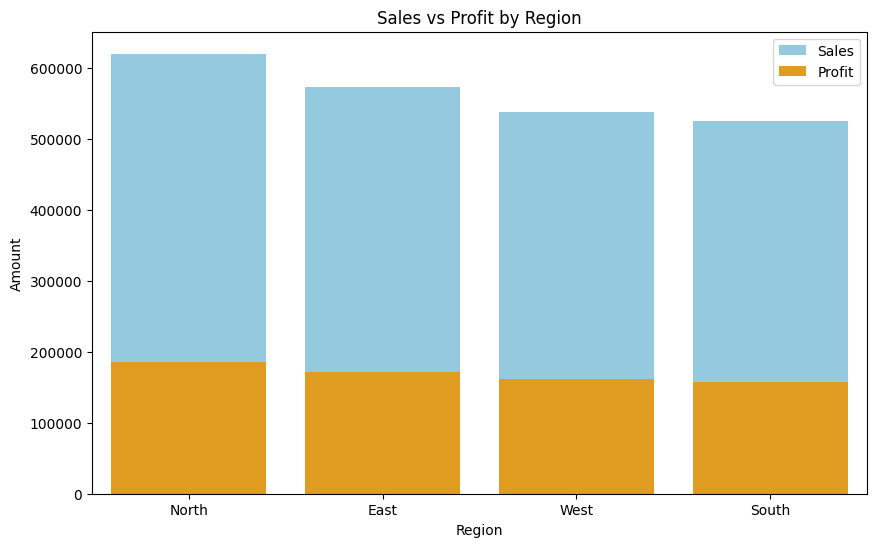

In [30]:
##  Sales & Profit by Segment
plt.figure(figsize=(10,6))
sns.barplot(x='region', y='total_sales', data=df_region, color='skyblue', label='Sales')
sns.barplot(x='region', y='total_profit', data=df_region, color='orange', label='Profit')
plt.title('Sales vs Profit by Region')
plt.ylabel('Amount')
plt.xlabel('Region')
plt.legend()
plt.show()




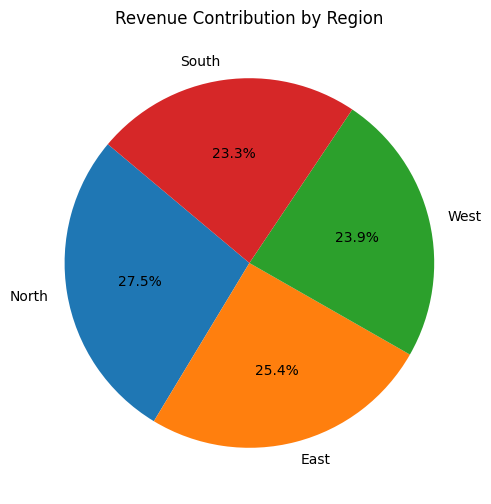

In [31]:
## Segment contribution to overall revenue
plt.figure(figsize=(6,6))
plt.pie(df_region['total_sales'], labels=df_region['region'], autopct='%1.1f%%', startangle=140)
plt.title('Revenue Contribution by Region')
plt.show()

### Trend Analysis

Create Customer Segments

In [ ]:
# Total Sales Per Customer
df_customer = df.groupby('customer_id').agg({
    'total_sales': 'sum'}).reset_index()

In [33]:
# Define segments base on total sales spend 
def segment(x):
    if x >= 10000:
        return 'High'
    elif x >= 5000:
        return 'Medium'
    else:
        return 'Low'
df_customer['segment'] = df_customer['total_sales'].apply(segment)

Merge

In [34]:
df_orders = df.merge(df_customer[['customer_id', 'segment']], on='customer_id', how='left')

Aggregate Monthly Sales by Segment

In [41]:
df_trend = df_orders.groupby(['order_year','order_month', 'segment']).agg(
    total_sales=('total_sales', 'sum')
).reset_index()

In [42]:
# Proper Datetime Column
df_trend['Order_Month'] = pd.to_datetime(
    df_trend['order_year'].astype(int).astype(str) + '-' +
    df_trend['order_month'].astype(int).astype(str) + '-01'
)

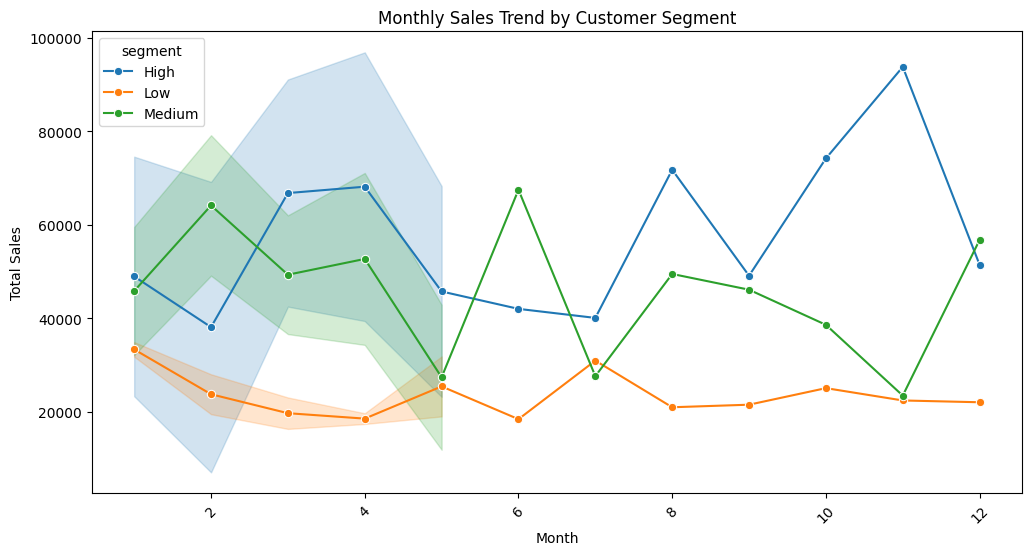

In [45]:
plt.figure(figsize=(12,6))
sns.lineplot(x='order_month', y='total_sales', hue='segment', data=df_trend, marker='o')
plt.title('Monthly Sales Trend by Customer Segment')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

### For VIZ

KPI Metrics by Segment

In [48]:
df_segment = df_orders.groupby('segment').agg(
    Total_Sales=('total_sales','sum'),
    Total_Profit=('total_sales', lambda x: x.sum()*0.3),  # Assuming 30% profit margin
    Unique_Customers=('customer_id','nunique')
).reset_index()

df_segment['AOV'] = df_segment['Total_Sales'] / df_segment['Unique_Customers']

print(df_segment)


  segment   Total_Sales   Total_Profit  Unique_Customers           AOV
0    High  1.000393e+06  300117.763541                70  14291.322073
1     Low  4.210660e+05  126319.793070               192   2193.051963
2  Medium  8.339793e+05  250193.786863               114   7315.607803


In [51]:
# Aggregate monthly sales
df_trend = df_orders.groupby(['order_year','order_month','segment']).agg(
    Total_Sales=('total_sales','sum')
).reset_index()

# Create datetime for plotting
df_trend['Order_Month'] = pd.to_datetime(
    df_trend['order_year'].astype(int).astype(str) + '-' +
    df_trend['order_month'].astype(int).astype(str) + '-01'
)


In [52]:
# Save the final dataset with segments and KPIs
df_orders.to_csv("Customer_Segmentation_Analysis.csv", index=False)
